In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time
import tqdm
import math
import random

In [3]:
df = pd.read_pickle('datasets/american_express/train_agg.pkl', compression='gzip')

In [4]:
target_col = 'target'

In [5]:
df.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,13,O,1,0,NaN,0,13,6.0,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,13,O,1,0,NaN,0,13,6.0,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,13,R,1,0,NaN,0,13,6.0,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,13,O,1,0,NaN,0,13,3.0,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,13,O,1,13,1.0,1,13,6.0,1,0


In [6]:
df.describe()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
count,456479.000000,451084.000000,456479.000000,456479.000000,456479.000000,458913.000000,453793.000000,458913.000000,458913.000000,4.589130e+05,...,458913.000000,458913.000000,458913.000000,458913.000000,59776.000000,458913.000000,458913.000000,453662.0,458913.000000,458913.000000
mean,NaN,0.049928,NaN,NaN,NaN,NaN,0.168938,0.000000,NaN,NaN,...,1.072127,11.579556,1.237546,1.358327,0.896973,0.130622,11.581603,NaN,1.407084,0.258934
std,0.000000,0.041742,0.000000,0.000000,0.000000,0.000000,0.155397,0.000000,0.000000,0.000000e+00,...,0.286462,3.299310,0.494283,3.862274,0.303467,0.338071,3.309711,0.0,0.669031,0.438050
min,-0.338379,0.000000,-0.458984,-0.338379,-0.458984,0.000001,0.000000,0.000000,0.000001,5.960464e-08,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.468262,0.022644,0.381348,0.550781,0.449463,0.019608,0.028252,0.000449,0.068604,4.783630e-03,...,1.000000,13.000000,1.000000,0.000000,1.000000,0.000000,13.000000,4.0,1.000000,0.000000
50%,0.678711,0.037454,0.604492,0.747559,0.682617,0.109802,0.163194,0.001150,0.476074,9.559631e-03,...,1.000000,13.000000,1.000000,0.000000,1.000000,0.000000,13.000000,6.0,1.000000,0.000000
75%,0.855957,0.063494,0.798340,0.907227,0.862305,0.230469,0.240191,0.002630,0.683105,2.666016e-01,...,1.000000,13.000000,1.000000,0.000000,1.000000,0.000000,13.000000,6.0,2.000000,1.000000
max,1.009766,0.468873,1.009766,1.009766,1.009766,4.593750,3.057598,4.445312,5.390625,5.000000e+00,...,6.000000,13.000000,4.000000,13.000000,1.000000,2.000000,13.000000,6.0,6.000000,1.000000


In [7]:
df[[target_col]].value_counts()

target
0         340085
1         118828
dtype: int64

In [8]:
df[[target_col]].value_counts()/len(df)

target
0         0.741066
1         0.258934
dtype: float64

In [9]:
from src.dataset import encode_categorical_features, null_columns

In [10]:
df = encode_categorical_features(df)
df = null_columns(df)

D_63_last
D_64_last


C:\Users\Aviv\PycharmProjects\thesis\src\dataset.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c + '_null'] = df[c].isna().astype(int)
C:\Users\Aviv\PycharmProjects\thesis\src\dataset.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c + '_null'] = df[c].isna().astype(int)
C:\Users\Aviv\PycharmProjects\thesis\src\dataset.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

# Try different train size and check results

In [11]:
from src.dataset import Dataset

In [12]:
from src.sampling_methods.sampling_methods import RandomSample, XgboostSubsample, TreeSample, CostumeSample, sampling_utils

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=0.2, shuffle = True)

In [14]:
dataset = Dataset(df, X_train, y_train, X_test, y_test, target_col, f1_score)

### regular methods

In [ ]:
random_sample = RandomSample('random')
xgboost_sample = XgboostSubsample('xgb_subsample')
tree_sample = TreeSample('tree')

### imblearn methods

In [19]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from functools import partial

In [20]:
def cluster_sample_function(dataset, p):
    values = list(dataset.y_train.unique())
    cnn = ClusterCentroids(estimator=MiniBatchKMeans(n_clusters=100),
                           sampling_strategy={v: math.ceil(p * len(dataset.y_train[dataset.y_train == v])) for v in values})
    X_real_train, y_real_train = cnn.fit_resample(X_train, y_train)
    return X_real_train, y_real_train

In [21]:
#cluster = CostumeSample('cluster', cluster_sample_function)

In [22]:
def cnn_sample_function(dataset, p):
    cnn = CondensedNearestNeighbour()
    X_real_train, y_real_train = cnn.fit_resample(dataset.X_train, dataset.y_train)
    return X_real_train, y_real_train

In [23]:
#cnn = CostumeSample('cnn', cnn_sample_function)

## Test

In [ ]:
random_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|          | 0/6 [00:00<?, ?it/s]

(0.782927400967419, 81.8572244644165, 0.050001361915397814)


 17%|█▋        | 1/6 [02:44<13:42, 164.58s/it]

(0.7862337223067817, 82.71554493904114, 0.050001361915397814)
(0.7885091001331728, 153.48061728477478, 0.10000272383079563)


 33%|███▎      | 2/6 [07:49<16:29, 247.33s/it]

(0.7873003753897053, 151.7570869922638, 0.10000272383079563)
(0.7929332514245768, 270.27941393852234, 0.2)


 50%|█████     | 3/6 [16:54<19:08, 382.94s/it]

(0.7919152459608075, 273.9989404678345, 0.2)
(0.7947258143029482, 377.60405921936035, 0.29999727616920435)


 67%|██████▋   | 4/6 [29:30<17:40, 530.42s/it]

(0.7952652716127668, 378.8456447124481, 0.29999727616920435)
(0.7948224445337451, 493.9257218837738, 0.4)


 83%|████████▎ | 5/6 [45:57<11:35, 695.10s/it]

(0.7976661099718833, 493.05940294265747, 0.4)
(0.7998224964604949, 888.5437924861908, 0.7499986380846022)


100%|██████████| 6/6 [1:15:38<00:00, 756.34s/it] 

(0.8008706493945605, 891.4941322803497, 0.7499986380846022)


In [ ]:
xgboost_sample.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False)

  0%|          | 0/6 [00:00<?, ?it/s]

(0.75165548947657, 535.5265779495239)


 17%|█▋        | 1/6 [17:55<1:29:36, 1075.30s/it]

(0.7518232700135686, 539.7769598960876)
(0.7697572588530374, 603.9988067150116)


 33%|███▎      | 2/6 [38:19<1:17:32, 1163.14s/it]

(0.7695150704135602, 620.6223282814026)
(0.7832709272069557, 729.5078058242798)


 50%|█████     | 3/6 [1:02:38<1:04:54, 1298.13s/it]

(0.7849416755037115, 729.1688115596771)
(0.7919428970834305, 851.8939003944397)


 67%|██████▋   | 4/6 [1:30:55<48:30, 1455.37s/it]  

(0.7954031729936413, 844.5174674987793)
(0.7941114170726541, 983.9172868728638)


 83%|████████▎ | 5/6 [2:03:40<27:19, 1639.34s/it]

(0.7959839357429719, 981.6222519874573)
(0.799577256393997, 1150.173627614975)


100%|██████████| 6/6 [2:41:56<00:00, 1619.48s/it]

(0.7995256548715668, 1146.0335478782654)


In [20]:
tree_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.7798742138364779, 11.708677053451538, 0.05091619302596063)


  0%|                                                                                            | 0/6 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
cluster.test_sample_method(dataset, print_results=True, trials_number=2, percents=sampling_utils.DEFAULT_PCT[:1])

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


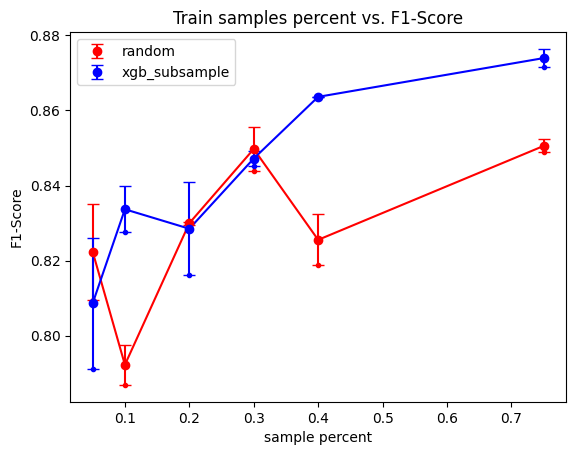

In [21]:
random_sample.print_scores()
xgboost_sample.print_scores('b')
#tree_sample.print_scores('g')
#cluster.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


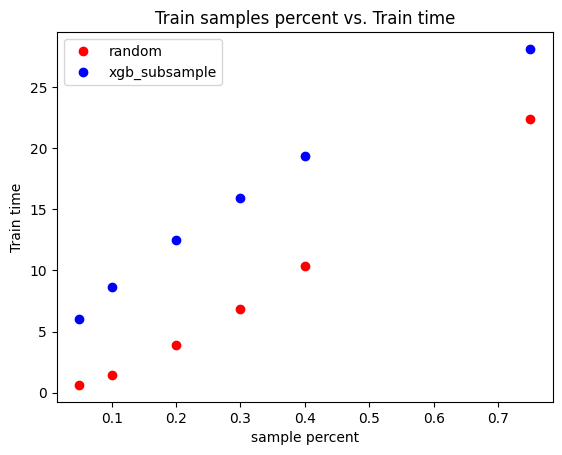

In [22]:
random_sample.print_times()
xgboost_sample.print_times('b')
#tree_sample.print_times('g')
#cluster.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

In [ ]:
random_sample.print_times()
xgboost_sample.print_times('b')
tree_sample.print_times('g')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')
plt.legend()

## Test small ps

In [35]:
small_pct = [0.001, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.05, 0.1]

In [43]:
random_small = RandomSample('random')
xgboost_small = XgboostSubsample('xgb_subsample')
tree_small = TreeSample('tree')

In [16]:
#cluster_small = CostumeSample('cluster', cluster_sample_function)

In [44]:
random_small.test_sample_method(dataset, trials_number=5, print_results=True, percents=small_pct)

  0%|          | 0/9 [00:00<?, ?it/s]

(0.7175841289186811, 6.31463623046875, 0.000999645901996568)
(0.7222023436801145, 5.941757678985596, 0.000999645901996568)
(0.7588270997718662, 6.00688624382019, 0.000999645901996568)
(0.7470462448970775, 6.084713697433472, 0.000999645901996568)


 11%|█         | 1/9 [00:30<04:03, 30.43s/it]

(0.7224878340305643, 6.085716485977173, 0.000999645901996568)
(0.7565892144962718, 8.339298963546753, 0.002998937705989704)
(0.7551407575394143, 8.284172058105469, 0.002998937705989704)
(0.7511326355256991, 8.441664695739746, 0.002998937705989704)
(0.7506060672243214, 8.204793930053711, 0.002998937705989704)


 22%|██▏       | 2/9 [01:12<04:19, 37.11s/it]

(0.7606933911159264, 8.505562543869019, 0.002998937705989704)
(0.7715283580810354, 11.22304391860962, 0.00499822950998284)
(0.7648898735826926, 10.913806200027466, 0.00499822950998284)
(0.7643396874463336, 11.406365156173706, 0.00499822950998284)
(0.7687386127706454, 11.093518018722534, 0.00499822950998284)


 33%|███▎      | 3/9 [02:07<04:33, 45.58s/it]

(0.7661272829812156, 11.016286373138428, 0.00499822950998284)
(0.7739262296832617, 14.211927652359009, 0.007000245144771607)
(0.7691708330627882, 14.24311113357544, 0.007000245144771607)
(0.7597992616010434, 14.622562646865845, 0.007000245144771607)
(0.7721418960767146, 14.703950643539429, 0.007000245144771607)


 44%|████▍     | 4/9 [03:20<04:40, 56.17s/it]

(0.7771608483842831, 14.62919807434082, 0.007000245144771607)
(0.7751231156319219, 19.52630853652954, 0.010001906681556942)
(0.7782160580226491, 19.745559453964233, 0.010001906681556942)
(0.7800033453207327, 19.312238931655884, 0.010001906681556942)
(0.777733042317391, 20.11353826522827, 0.010001906681556942)


 56%|█████▌    | 5/9 [04:59<04:46, 71.66s/it]

(0.7714285714285715, 20.421106338500977, 0.010001906681556942)
(0.7766778092054513, 29.770468950271606, 0.015000136191539781)
(0.7773902687989112, 30.07607126235962, 0.015000136191539781)
(0.7820665588560729, 28.50071406364441, 0.015000136191539781)
(0.7801090792428617, 28.3844211101532, 0.015000136191539781)


 67%|██████▋   | 6/9 [07:24<04:49, 96.46s/it]

(0.7797650545031221, 27.84746551513672, 0.015000136191539781)
(0.7827600849256899, 37.00587058067322, 0.02000108953231825)
(0.7826733198853381, 38.42997884750366, 0.02000108953231825)
(0.781659950270085, 38.115766286849976, 0.02000108953231825)
(0.7847457989024834, 42.96387577056885, 0.02000108953231825)


 78%|███████▊  | 7/9 [9:25:48<6:07:16, 11018.46s/it]

(0.7807851327735391, 33348.35688519478, 0.02000108953231825)
(0.7861425998516791, 91.6011688709259, 0.050001361915397814)
(0.7838990278014667, 85.80660510063171, 0.050001361915397814)
(0.7852316295621596, 86.26663947105408, 0.050001361915397814)
(0.7876531654186523, 84.52361941337585, 0.050001361915397814)


 89%|████████▉ | 8/9 [9:33:01<2:07:28, 7648.43s/it] 

(0.7847312608018434, 84.40343999862671, 0.050001361915397814)
(0.789004394861393, 144.74828267097473, 0.10000272383079563)
(0.7882899116019758, 1399.8017418384552, 0.10000272383079563)
(0.7850626289262701, 148.3153007030487, 0.10000272383079563)
(0.7863054607508533, 140.85030722618103, 0.10000272383079563)


100%|██████████| 9/9 [10:06:01<00:00, 4040.19s/it] 

(0.7874262927926018, 146.4475486278534, 0.10000272383079563)


In [18]:
xgboost_small.test_sample_method(dataset, trials_number=5, print_results=True, update_pcts=False, percents=small_pct)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(0.6978847019352727, 457.7283344268799)
(0.7043055097327615, 422.76144003868103)
(0.7043055097327615, 413.5432081222534)
(0.6702547396960928, 414.89528250694275)
(0.6882701198719692, 457.5657112598419)


 11%|████████▉                                                                       | 1/9 [36:06<4:48:53, 2166.73s/it]

(0.6881466276875867, 487.7660665512085)
(0.7020033388981636, 484.88838744163513)
(0.7020033388981636, 493.19382333755493)
(0.699295482801492, 505.8479073047638)


 22%|█████████████████▎                                                            | 2/9 [1:17:05<4:32:48, 2338.32s/it]

(0.6930856213054314, 485.93172693252563)
(0.696295075890191, 477.80500054359436)
(0.7042347588337196, 497.3455402851105)
(0.6956790887705832, 500.2407269477844)
(0.6956790887705832, 472.24060344696045)


 33%|██████████████████████████                                                    | 3/9 [1:57:28<3:57:42, 2377.02s/it]

(0.6893960301454198, 475.27953696250916)
(0.7074052765677654, 483.0245723724365)
(0.7094752673796793, 487.2569215297699)
(0.7045496904056825, 466.756893157959)
(0.6939996629024102, 519.940268278122)


 44%|██████████████████████████████████▋                                           | 4/9 [2:38:52<3:21:37, 2419.43s/it]

(0.6947010108138401, 527.2669472694397)
(0.7150436631639795, 585.8745539188385)
(0.707251828631139, 550.5256605148315)
(0.7009228810862417, 534.2620234489441)
(0.7155948017327557, 552.569563627243)


 56%|███████████████████████████████████████████▎                                  | 5/9 [3:25:11<2:49:55, 2548.88s/it]

(0.7155948017327557, 554.9950132369995)
(0.7142528975670879, 608.759762763977)
(0.7105989626903128, 571.9271693229675)
(0.7170008791392807, 567.3737487792969)
(0.7142528975670879, 612.5740089416504)


 67%|████████████████████████████████████████████████████                          | 6/9 [4:14:47<2:14:43, 2694.35s/it]

(0.7097907949790795, 615.6942536830902)
(0.7230698490991933, 575.1491649150848)
(0.7214544223158162, 534.208781003952)
(0.7240061002360707, 532.304877281189)
(0.7253122398001666, 532.0056691169739)


 78%|████████████████████████████████████████████████████████████▋                 | 7/9 [5:00:00<1:30:00, 2700.33s/it]

(0.72352891939399, 538.4782452583313)
(0.7561519370714676, 583.4809513092041)
(0.754843075881905, 593.9888925552368)
(0.7561641516222565, 581.0491921901703)
(0.7566791879458067, 590.669908285141)


 89%|███████████████████████████████████████████████████████████████████████         | 8/9 [5:49:05<46:18, 2778.05s/it]

(0.752935710061671, 594.9217290878296)
(0.7715930902111325, 665.1176924705505)
(0.773269186132388, 657.2395439147949)
(0.7734599156118143, 645.2982573509216)
(0.7734599156118143, 641.9995319843292)
(0.7772735906798083, 639.2548751831055)


100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [6:43:14<00:00, 2688.28s/it]


In [ ]:
tree_small.test_sample_method(dataset, trials_number=5, print_results=True, percents=small_pct)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(0.2437676047068734, 3865.1844708919525, 0.05482526625446027)


In [ ]:
#cluster_small.test_sample_method(dataset, print_results=True, trials_number=2, percents=small_pct)

In [ ]:
random_small.print_scores()
xgboost_small.print_scores('b')
tree_small.print_scores('g')
#cluster_small.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

In [ ]:
random_small.print_times()
xgboost_small.print_times('b')
tree_small.print_times('g')
cluster_small.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

## Visualize decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [16]:
singel_tree_model = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, class_weight='balanced')

In [17]:
s = time.time()
singel_tree_model.fit(X_train.fillna(0), y_train)
time.time() - s

148.39929461479187

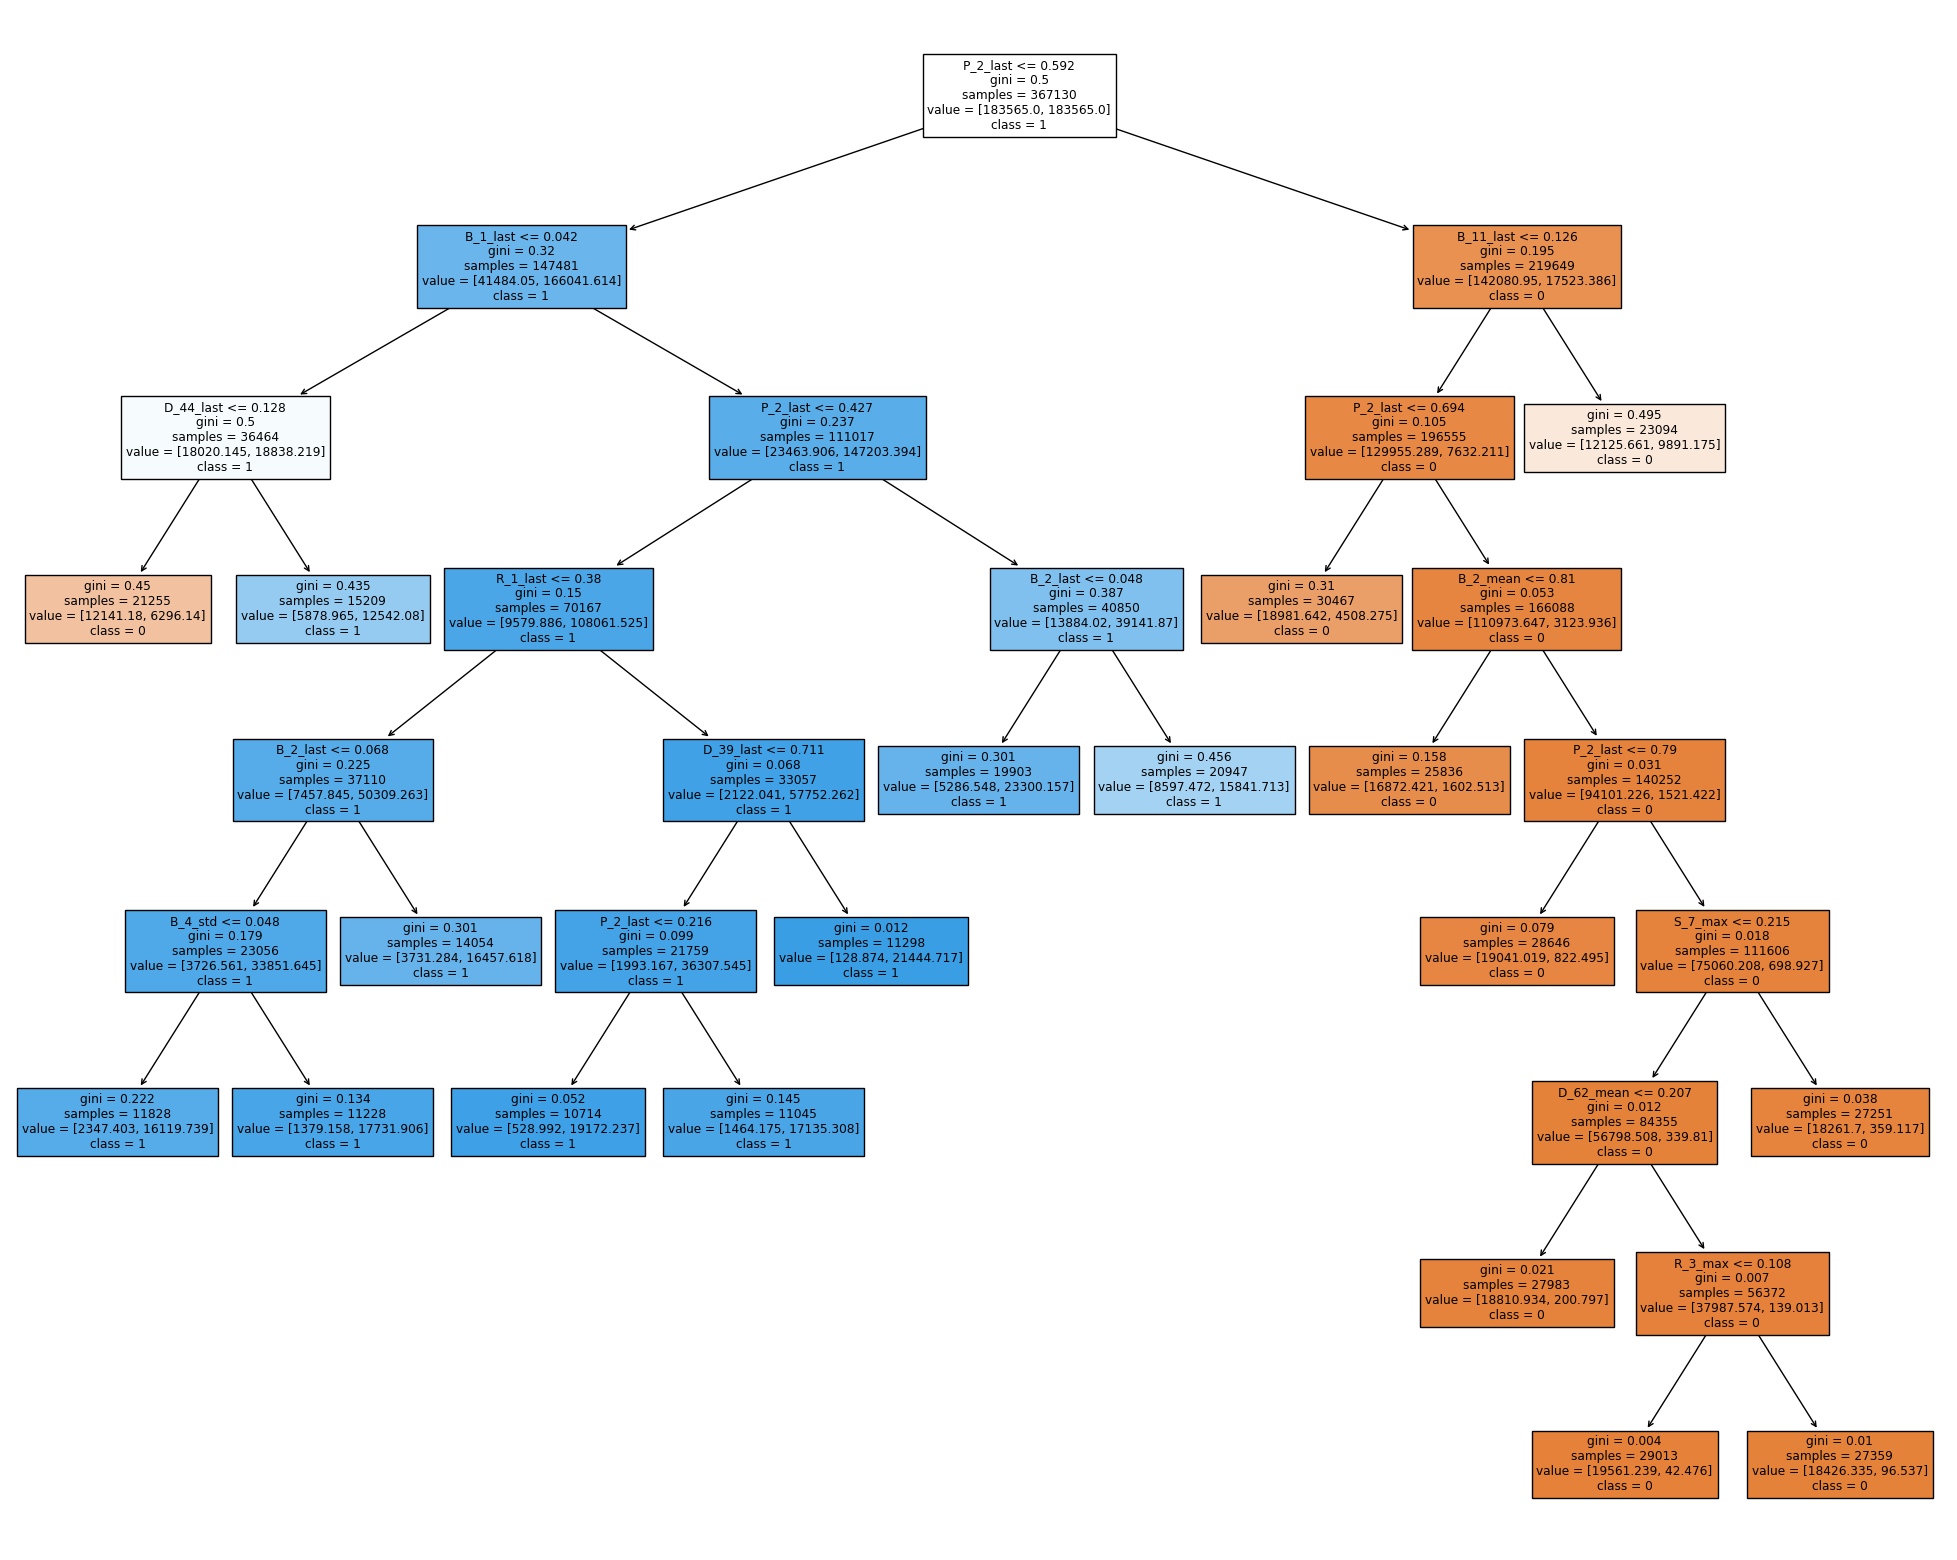

In [18]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(singel_tree_model, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True,
                   )

## XGBoost paths

In [19]:
from src.gbdt_model_paths.model_path import ModelPath

In [20]:
model_path = ModelPath(xgb.XGBClassifier(max_depth=3), dataset)

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'diff_{n}'] = round(self.X_diff[f'pred_{n}'] - self.X_diff[f'pred_{n - 1}'], 5)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'pred_{n}'] = model.predict(dataset.X_train, iteration_range=(0, n+1), output_margin=True)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarnin

### EDA

In [21]:
#for num_trees in range(0, model_path.num_trees, 5):
for num_trees in range(0, 31, 5):
    print(f'trees number: {num_trees}')
    model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(num_trees + 1)]))
    print('\n')

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


trees number: 0
1: 0, 0: 0, all: 8
part of groups: 0.0
part of examples: 0.0


trees number: 5
1: 1083, 0: 562, all: 3969
part of groups: 0.4144620811287478
part of examples: 0.015653855582491216


trees number: 10
1: 32748, 0: 34720, all: 79097
part of groups: 0.8529779890514179
part of examples: 0.29924822270040585


trees number: 15
1: 75401, 0: 97746, all: 178047
part of groups: 0.9724791768465629
part of examples: 0.6732710484024732


trees number: 20
1: 92035, 0: 137983, all: 231167
part of groups: 0.9950295673690449
part of examples: 0.8569444066134612


trees number: 25
1: 94594, 0: 185033, all: 279953
part of groups: 0.9988355188192304
part of examples: 0.9494102906327458


trees number: 30
1: 94916, 0: 218162, all: 313225
part of groups: 0.9995306888019794
part of examples: 0.9847383760520797




(array([2.60167e+05, 1.24620e+04, 1.46200e+03, 1.20000e+02]),
 array([   1.,    2.,   10.,  100., 1000.]),
 <BarContainer object of 4 artists>)

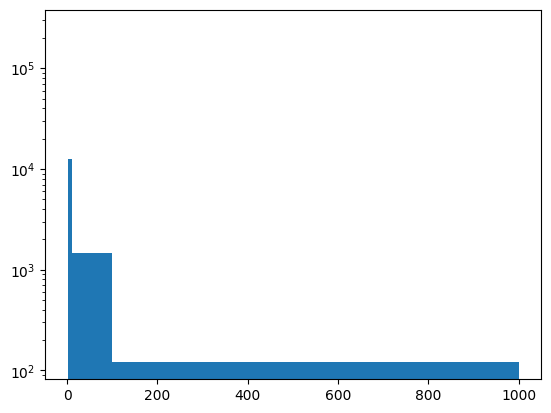

In [22]:
grouped_df = model_path.X_diff.groupby([f'diff_{i}' for i in range(25)]).count()[[target_col]]
plt.hist(grouped_df[target_col], log=True, bins=[1,2,10,100,1000])

In [23]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.1696074959823496

In [24]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.1696074959823496

(array([2.78442e+05, 7.99000e+02, 2.59000e+02, 1.40000e+02, 7.00000e+01,
        4.40000e+01, 2.70000e+01, 2.10000e+01, 1.90000e+01, 2.20000e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

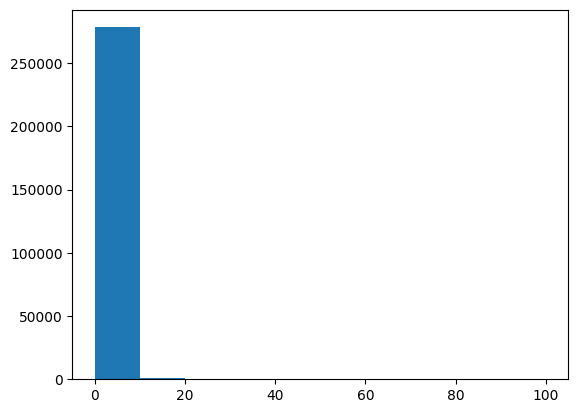

In [25]:
plt.hist(counts, range=(0, 100))

(array([1.85128e+05, 2.50000e+01, 3.50000e+01, 2.80000e+01, 1.00000e+00,
        1.39000e+02, 3.00000e+00, 0.00000e+00, 0.00000e+00, 9.45940e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

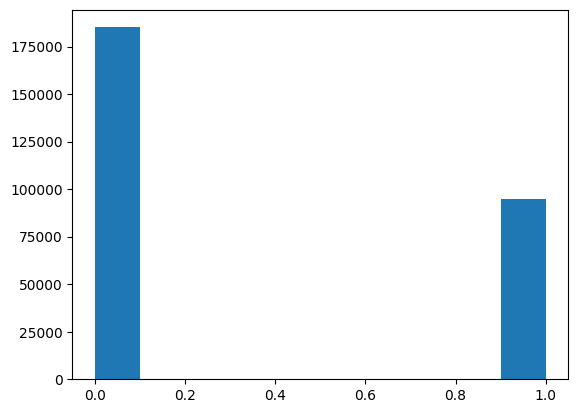

In [26]:
plt.hist(ratios)

In [27]:
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.1696074959823496

In [28]:
len(counts) / sum(counts)

0.7625446027292785

### Sample by leafs combinations

In [29]:
from src.sampling_methods.sampling_base import Experiment

In [30]:
class XgboostPathSampleA(Experiment):

    def __init__(self, name, model_path: ModelPath, trees_to_use=None, model=None, use_target=True):
        super().__init__(name, model)
        self.model_path = model_path
        self.trees_to_use = trees_to_use if trees_to_use else model_path.num_trees
        if use_target:
            self.groupby_columns = [f'diff_{i}' for i in range(self.trees_to_use)] + [model_path.datset.target_col]
        else:
            self.groupby_columns = [f'diff_{i}' for i in range(self.trees_to_use)]
        self.leaves_groupes = model_path.X_diff.groupby(self.groupby_columns, as_index=False)

    def sample_func(self, dataset: Dataset, p):
        s = time.time()

        sampled = sampling_utils.sample_from_groups_round_up(self.leaves_groupes, p)
        X_real_train = dataset.X_train.loc[sampled.index]
        y_real_train = dataset.y_train.loc[sampled.index]

        # Get the weights
        self.model_path.X_diff['joined'] = self.model_path.X_diff.apply(
            lambda row: '_'.join(self.groupby_columns), axis=1)
        weight = self.model_path.X_diff.groupby('joined').count()[[dataset.target_col]].rename(
            columns={dataset.target_col: 'weight'}).reset_index()
        sampled_count = self.model_path.X_diff.loc[sampled.index, :].groupby('joined').count()[[dataset.target_col]].rename(
            columns={dataset.target_col: 'sampled_weight'}).reset_index()
        merged = self.model_path.X_diff[['joined']].reset_index()\
            .merge(weight, on='joined').\
            merge(sampled_count, on='joined').set_index('customer_ID')
        merged['normed_weight'] = merged.apply(lambda row: row['weight'] / row['sampled_weight'], axis=1)
        normed_weight = merged.loc[sampled.index, 'normed_weight']
        self.model_path.X_diff.drop(columns=['joined'], inplace=True)

        self.model.fit(X_real_train, y_real_train, sample_weight=normed_weight)
        return dataset.metric(dataset.y_test, self.model.predict(dataset.X_test)), \
               time.time() - s, \
               len(X_real_train) / len(dataset.X_train)


In [31]:
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'w', 'pink'] 

In [32]:
from src.sampling_methods.sampling_methods import XgboostPathSample

In [33]:
experimets = [XgboostPathSampleA(f'{i} trees', model_path, i) for i in [1, 2, 3, 5, 7, 10, 13, 20]]

In [36]:
for e in experimets:
    print ('#######################################')
    e.test_sample_method(dataset, print_results=True, trials_number=5, percents=small_pct)

#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.6953594614089926, 11.105851173400879, 0.0010241603791572467)
(0.7372924218157295, 9.536583423614502, 0.0010241603791572467)
(0.7078191013340549, 9.5767343044281, 0.0010241603791572467)
(0.6549182672210855, 9.606889486312866, 0.0010241603791572467)


 11%|█         | 1/9 [00:49<06:37, 49.64s/it]

(0.7009796565842783, 9.78392219543457, 0.0010241603791572467)
(0.7594827956527341, 12.59342622756958, 0.0030288998447416445)
(0.7695646623260565, 12.616381645202637, 0.0030288998447416445)
(0.7738510792109883, 12.729807376861572, 0.0030288998447416445)
(0.7663567273808007, 12.619884967803955, 0.0030288998447416445)


 22%|██▏       | 2/9 [01:52<06:42, 57.53s/it]

(0.762267199591802, 12.46199369430542, 0.0030288998447416445)
(0.7654299546273581, 16.359707355499268, 0.005011848663960995)
(0.7716794037769216, 16.31636953353882, 0.005011848663960995)
(0.772699862164025, 16.72049880027771, 0.005011848663960995)
(0.7718946154831547, 16.196279048919678, 0.005011848663960995)


 33%|███▎      | 3/9 [03:14<06:52, 68.72s/it]

(0.7752709484249145, 16.399327993392944, 0.005011848663960995)
(0.7797758554565986, 20.928163290023804, 0.0070165881295453925)
(0.7799705449189985, 20.24143385887146, 0.0070165881295453925)
(0.772559457370997, 20.465837240219116, 0.0070165881295453925)
(0.7776492761072561, 21.33250665664673, 0.0070165881295453925)


 44%|████▍     | 4/9 [04:58<06:53, 82.67s/it]

(0.7764983381580358, 21.052637338638306, 0.0070165881295453925)
(0.7767217865666552, 26.908607006072998, 0.010015525835535097)
(0.7791367977707346, 25.948030948638916, 0.010015525835535097)
(0.7776154672395273, 25.967118501663208, 0.010015525835535097)
(0.7780263271100405, 26.134233474731445, 0.010015525835535097)


 56%|█████▌    | 5/9 [07:09<06:40, 100.05s/it]

(0.7736828445367246, 25.874252796173096, 0.010015525835535097)
(0.7761335283489633, 36.32740354537964, 0.015019203007109199)
(0.7800759094204444, 35.50590682029724, 0.015019203007109199)
(0.7801954951126222, 35.15033221244812, 0.015019203007109199)
(0.7827258726899384, 35.09961676597595, 0.015019203007109199)


 67%|██████▋   | 6/9 [10:06<06:18, 126.31s/it]

(0.7800149460873279, 35.17077374458313, 0.015019203007109199)
(0.7808654481861417, 45.05229473114014, 0.02002015634788767)
(0.7844503333903231, 43.633143186569214, 0.02002015634788767)
(0.7809609455292909, 44.887545347213745, 0.02002015634788767)
(0.77989415722152, 43.61575102806091, 0.02002015634788767)


 78%|███████▊  | 7/9 [13:49<05:15, 157.69s/it]

(0.782571840298381, 45.05046892166138, 0.02002015634788767)
(0.7826254002134473, 87.48430347442627, 0.05002042873096723)
(0.7853601446962444, 87.69119501113892, 0.05002042873096723)
(0.7833128418196463, 89.91967272758484, 0.05002042873096723)
(0.7849754112260471, 87.51321625709534, 0.05002042873096723)


 89%|████████▉ | 8/9 [21:12<04:08, 248.56s/it]

(0.7851990552588463, 90.4645562171936, 0.05002042873096723)
(0.7865383389636051, 155.63540863990784, 0.10001906681556942)
(0.7882065966698483, 158.3493812084198, 0.10001906681556942)
(0.7890397056958011, 157.1639063358307, 0.10001906681556942)
(0.7858475366742984, 158.22357177734375, 0.10001906681556942)


100%|██████████| 9/9 [34:18<00:00, 228.76s/it]


(0.7878646638842397, 157.0643527507782, 0.10001906681556942)
#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.6605131217352996, 10.063890933990479, 0.001114046795413069)
(0.6920011082930156, 9.752588987350464, 0.001114046795413069)
(0.6338701114846931, 9.918338060379028, 0.001114046795413069)
(0.7290583477758521, 9.928136110305786, 0.001114046795413069)


 11%|█         | 1/9 [00:49<06:35, 49.40s/it]

(0.6896005630828788, 9.70051121711731, 0.001114046795413069)
(0.7633006198347106, 13.080775022506714, 0.0031078909378149428)
(0.7677180275403209, 13.206573247909546, 0.0031078909378149428)
(0.7603334341122101, 12.822093486785889, 0.0031078909378149428)
(0.7618924341466572, 12.88444447517395, 0.0031078909378149428)


 22%|██▏       | 2/9 [01:54<06:50, 58.58s/it]

(0.7650324166278233, 12.977018356323242, 0.0031078909378149428)
(0.7805263607621978, 16.44973063468933, 0.0051071827418080785)
(0.7729269690345311, 16.497373819351196, 0.0051071827418080785)
(0.7752765957446809, 16.393082857131958, 0.0051071827418080785)
(0.7746316954781572, 16.47746443748474, 0.0051071827418080785)


 33%|███▎      | 3/9 [03:16<06:56, 69.42s/it]

(0.7701787884047907, 16.462120056152344, 0.0051071827418080785)
(0.7748337243591124, 20.624631881713867, 0.007098303053414322)
(0.7748726655348047, 20.537182092666626, 0.007098303053414322)
(0.7798947481473526, 20.26571297645569, 0.007098303053414322)
(0.773747171031361, 20.581515789031982, 0.007098303053414322)


 44%|████▍     | 4/9 [04:59<06:51, 82.39s/it]

(0.7718641002454463, 20.243725061416626, 0.007098303053414322)
(0.7748554851645655, 26.164804220199585, 0.010094516928608395)
(0.779476493227583, 25.787187576293945, 0.010094516928608395)
(0.7785343778683801, 26.415541887283325, 0.010094516928608395)
(0.7792668590360159, 26.271254777908325, 0.010094516928608395)


 56%|█████▌    | 5/9 [07:09<06:39, 99.81s/it]

(0.7723136118977108, 26.02241563796997, 0.010094516928608395)
(0.7811404633666752, 36.51530480384827, 0.01510636559256939)
(0.783665822138006, 36.574944734573364, 0.01510636559256939)
(0.7798466126970599, 35.55062127113342, 0.01510636559256939)
(0.7840322269600806, 35.31699991226196, 0.01510636559256939)


 67%|██████▋   | 6/9 [10:08<06:20, 126.78s/it]

(0.7770736333850664, 35.13842415809631, 0.01510636559256939)
(0.7813284541083358, 43.02963924407959, 0.020096423610165337)
(0.7822286344733939, 45.12056803703308, 0.020096423610165337)
(0.7780440830301734, 44.51977849006653, 0.020096423610165337)
(0.7843387052253861, 44.587342977523804, 0.020096423610165337)


 78%|███████▊  | 7/9 [13:49<05:15, 157.57s/it]

(0.7805541968823767, 43.64112901687622, 0.020096423610165337)
(0.7821016659547203, 91.31802821159363, 0.05010486748563179)
(0.7848036715961244, 86.52629065513611, 0.05010486748563179)
(0.7822632320902217, 88.2453384399414, 0.05010486748563179)
(0.7860258310395934, 88.6319899559021, 0.05010486748563179)


 89%|████████▉ | 8/9 [21:20<04:10, 250.93s/it]

(0.786224080408801, 96.06460976600647, 0.05010486748563179)
(0.7840779165784459, 158.5007026195526, 0.10010078173943834)
(0.7893970411328957, 156.92661714553833, 0.10010078173943834)
(0.7892728429086282, 156.31104063987732, 0.10010078173943834)
(0.7868928851327021, 156.2726182937622, 0.10010078173943834)


100%|██████████| 9/9 [34:23<00:00, 229.25s/it]


(0.785496441884107, 154.5165240764618, 0.10010078173943834)
#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.7308847308847308, 11.26356029510498, 0.0015879933538528587)
(0.7513641511376508, 10.962001085281372, 0.0015879933538528587)
(0.7271605200995936, 10.943912744522095, 0.0015879933538528587)
(0.7502815603563019, 11.047068119049072, 0.0015879933538528587)


 11%|█         | 1/9 [00:55<07:21, 55.23s/it]

(0.7281938809079943, 10.981130838394165, 0.0015879933538528587)
(0.7590478872019233, 14.339750528335571, 0.003524637049546482)
(0.7671875991287245, 14.116080045700073, 0.003524637049546482)
(0.7614575106196769, 14.456374883651733, 0.003524637049546482)
(0.762084864968234, 14.351612329483032, 0.003524637049546482)


 22%|██▏       | 2/9 [02:06<07:32, 64.64s/it]

(0.7642519817844494, 13.92189908027649, 0.003524637049546482)
(0.7616162053368536, 17.75275707244873, 0.00547217606842263)
(0.7737476946558413, 17.652820110321045, 0.00547217606842263)
(0.7708944517013213, 17.703829288482666, 0.00547217606842263)
(0.7660604502709765, 17.660160303115845, 0.00547217606842263)


 33%|███▎      | 3/9 [03:35<07:33, 75.61s/it]

(0.7678869621066152, 17.847764015197754, 0.00547217606842263)
(0.7712554112554112, 22.355907201766968, 0.007468744041620135)
(0.7713663699264975, 21.976505994796753, 0.007468744041620135)
(0.776361034578501, 22.39890193939209, 0.007468744041620135)
(0.7747204583841105, 21.485118627548218, 0.007468744041620135)


 44%|████▍     | 4/9 [05:24<07:25, 89.06s/it]

(0.7789043232646867, 21.435361862182617, 0.007468744041620135)
(0.7804542326221611, 27.360701084136963, 0.01044044343965353)
(0.7763469793068102, 27.1924946308136, 0.01044044343965353)
(0.7785683851725608, 28.709891319274902, 0.01044044343965353)
(0.7793445284792548, 30.492669820785522, 0.01044044343965353)


 56%|█████▌    | 5/9 [07:52<07:20, 110.16s/it]

(0.7740717432347389, 33.756322145462036, 0.01044044343965353)
(0.7838277896428495, 37.505974531173706, 0.015435949118840737)
(0.775712143928036, 37.83112907409668, 0.015435949118840737)
(0.7807475196715703, 36.91247320175171, 0.015435949118840737)
(0.7775442809966976, 35.835365295410156, 0.015435949118840737)


 67%|██████▋   | 6/9 [10:58<06:47, 135.96s/it]

(0.7803274489294939, 37.93648052215576, 0.015435949118840737)
(0.7780930272547503, 44.40227007865906, 0.02040694032086727)
(0.7802374077638755, 43.74350357055664, 0.02040694032086727)
(0.7820138518913159, 43.93967247009277, 0.02040694032086727)
(0.7811887933236822, 43.84762263298035, 0.02040694032086727)


 78%|███████▊  | 7/9 [14:39<05:27, 163.86s/it]

(0.7800389463097301, 45.313199281692505, 0.02040694032086727)
(0.7826925549697826, 87.03866124153137, 0.0503609075804211)
(0.7856840501185236, 89.00494313240051, 0.0503609075804211)
(0.7846586311171685, 90.05872511863708, 0.0503609075804211)
(0.7860087551532152, 81.01579546928406, 0.0503609075804211)


 89%|████████▉ | 8/9 [21:47<04:07, 247.82s/it]

(0.7849141786277098, 80.3899199962616, 0.0503609075804211)
(0.7878865266338929, 156.69908475875854, 0.1003432026802495)
(0.7861178369652945, 156.4007785320282, 0.1003432026802495)
(0.7852022039270746, 156.85322165489197, 0.1003432026802495)
(0.7874440223273977, 156.87695407867432, 0.1003432026802495)


100%|██████████| 9/9 [34:50<00:00, 232.30s/it]


(0.788155187408523, 156.46265602111816, 0.1003432026802495)
#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.7209141709047528, 26.37064838409424, 0.008261378803148749)
(0.7029519500107735, 26.595293760299683, 0.008261378803148749)
(0.709400793225426, 25.578726291656494, 0.008261378803148749)
(0.7240198268343012, 26.254144430160522, 0.008261378803148749)


 11%|█         | 1/9 [02:11<17:29, 131.16s/it]

(0.7245058448459086, 26.319612979888916, 0.008261378803148749)
(0.7484028641255414, 29.463151454925537, 0.009852095987797238)
(0.7442910592181653, 29.302133083343506, 0.009852095987797238)
(0.7470559319498172, 28.91111922264099, 0.009852095987797238)
(0.7485225405901303, 27.994582176208496, 0.009852095987797238)


 22%|██▏       | 2/9 [04:35<16:12, 138.89s/it]

(0.7468833765902226, 28.59237575531006, 0.009852095987797238)
(0.7584101775956285, 30.761733531951904, 0.011603519189387955)
(0.7605537221960313, 32.24017596244812, 0.011603519189387955)
(0.7537936511343393, 32.22611403465271, 0.011603519189387955)
(0.754359591100421, 30.87225842475891, 0.011603519189387955)


 33%|███▎      | 3/9 [07:13<14:45, 147.60s/it]

(0.7547514387037864, 31.81286382675171, 0.011603519189387955)
(0.7587080158815324, 34.07963728904724, 0.013401247514504399)
(0.7563843941800078, 34.77606749534607, 0.013401247514504399)
(0.7644767924407841, 34.889018058776855, 0.013401247514504399)
(0.7565496308096356, 34.91816186904907, 0.013401247514504399)


 44%|████▍     | 4/9 [10:06<13:07, 157.47s/it]

(0.7572310692232694, 33.89838194847107, 0.013401247514504399)
(0.7659256092347158, 39.16589593887329, 0.016182278756843624)
(0.7691947764685866, 39.35547137260437, 0.016182278756843624)
(0.7659027629042622, 39.646512269973755, 0.016182278756843624)
(0.7677300403052911, 39.56108570098877, 0.016182278756843624)


 56%|█████▌    | 5/9 [13:24<11:28, 172.17s/it]

(0.7706628695301043, 40.47067594528198, 0.016182278756843624)
(0.7716373012462397, 46.98803758621216, 0.020889058371693952)
(0.7735044557199504, 46.794623613357544, 0.020889058371693952)
(0.7709415966296701, 47.05134344100952, 0.020889058371693952)
(0.772681288878366, 46.910377979278564, 0.020889058371693952)


 67%|██████▋   | 6/9 [17:19<09:41, 193.78s/it]

(0.7699099871410201, 47.917009353637695, 0.020889058371693952)
(0.7722272163006719, 52.925944089889526, 0.025693895895186992)
(0.7762819413479677, 54.70109939575195, 0.025693895895186992)
(0.7771115080377647, 55.7395122051239, 0.025693895895186992)
(0.7754026730637422, 54.50963497161865, 0.025693895895186992)


 78%|███████▊  | 7/9 [21:53<07:19, 219.79s/it]

(0.7758793969849246, 55.40414881706238, 0.025693895895186992)
(0.7812693069728797, 95.27997469902039, 0.054912428839920466)
(0.7801297005757336, 96.40315413475037, 0.054912428839920466)
(0.7821513330910179, 94.80054879188538, 0.054912428839920466)
(0.7836799180152867, 96.73481726646423, 0.054912428839920466)


 89%|████████▉ | 8/9 [29:53<05:02, 302.69s/it]

(0.7818619616868036, 96.92622947692871, 0.054912428839920466)
(0.7865416436845007, 160.33368039131165, 0.10430637648789257)
(0.7864052953156823, 160.97371125221252, 0.10430637648789257)
(0.7892505934214988, 164.49663829803467, 0.10430637648789257)
(0.786773428232503, 162.7459840774536, 0.10430637648789257)


100%|██████████| 9/9 [43:23<00:00, 289.32s/it]


(0.7857704152065413, 161.65616655349731, 0.10430637648789257)
#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.7335655830636351, 90.64945840835571, 0.0470541769945251)
(0.736664887282881, 89.50514698028564, 0.0470541769945251)
(0.7333223317793639, 90.15648531913757, 0.0470541769945251)
(0.730737637588303, 89.95717692375183, 0.0470541769945251)


 11%|█         | 1/9 [07:30<1:00:04, 450.50s/it]

(0.7318534825414297, 90.16974210739136, 0.0470541769945251)
(0.7475863214500758, 91.32157754898071, 0.04825266254460273)
(0.7378174760523406, 91.37412881851196, 0.04825266254460273)
(0.7458322965911918, 90.93087267875671, 0.04825266254460273)
(0.7441128347451484, 91.8820309638977, 0.04825266254460273)


 22%|██▏       | 2/9 [15:08<53:02, 454.70s/it]  

(0.7454023466755431, 92.06400156021118, 0.04825266254460273)
(0.7505035612683514, 93.16515636444092, 0.049530139187753654)
(0.7489608789188964, 93.8413622379303, 0.049530139187753654)
(0.7513178813488411, 94.46893548965454, 0.049530139187753654)
(0.7456527165321574, 94.08643960952759, 0.049530139187753654)


 33%|███▎      | 3/9 [22:58<46:11, 461.87s/it]

(0.747946751374057, 94.77425336837769, 0.049530139187753654)
(0.7544885264318557, 95.28574752807617, 0.050954702693868655)
(0.7530892688555544, 95.71871018409729, 0.050954702693868655)
(0.7491606513345643, 95.61889123916626, 0.050954702693868655)
(0.754886841995582, 96.22170066833496, 0.050954702693868655)


 44%|████▍     | 4/9 [30:58<39:04, 468.91s/it]

(0.7558426355616874, 96.79480648040771, 0.050954702693868655)
(0.7564236473783162, 99.28144097328186, 0.053204586931059845)
(0.7570989782486052, 99.38465785980225, 0.053204586931059845)
(0.7600234368460702, 98.78695678710938, 0.053204586931059845)
(0.7601554663991975, 97.85955595970154, 0.053204586931059845)


 56%|█████▌    | 5/9 [39:12<31:52, 478.19s/it]

(0.7590975558805098, 99.24894213676453, 0.053204586931059845)
(0.7662269571964851, 104.49418449401855, 0.05712690327676845)
(0.7659038421163132, 104.04782485961914, 0.05712690327676845)
(0.7621858660819699, 104.39143562316895, 0.05712690327676845)
(0.7623558137576829, 104.23308753967285, 0.05712690327676845)


 67%|██████▋   | 6/9 [47:55<24:39, 493.19s/it]

(0.7615688250608885, 105.07697772979736, 0.05712690327676845)
(0.7664453577826958, 110.24055552482605, 0.06120720180862365)
(0.7692792206428857, 108.59900259971619, 0.06120720180862365)
(0.765847835647421, 109.61006760597229, 0.06120720180862365)
(0.765913843580092, 110.15702295303345, 0.06120720180862365)


 78%|███████▊  | 7/9 [57:03<17:02, 511.13s/it]

(0.7681464338312646, 109.37573552131653, 0.06120720180862365)
(0.7820968834688347, 143.22178626060486, 0.08714079481382617)
(0.7764681075382182, 143.31734824180603, 0.08714079481382617)
(0.7777518111708344, 144.1661503314972, 0.08714079481382617)
(0.7810198957739941, 144.09676027297974, 0.08714079481382617)


 89%|████████▉ | 8/9 [1:09:01<09:37, 577.15s/it]

(0.7805052481016387, 143.61914038658142, 0.08714079481382617)
(0.7878017789072426, 203.38812923431396, 0.13281398959496635)
(0.7843377826666385, 204.84915328025818, 0.13281398959496635)
(0.7881906940296928, 206.64371752738953, 0.13281398959496635)
(0.7847003824904377, 204.4570231437683, 0.13281398959496635)


100%|██████████| 9/9 [1:26:04<00:00, 573.86s/it]


(0.7871366833319211, 203.45933389663696, 0.13281398959496635)
#######################################


  0%|          | 0/9 [00:00<?, ?it/s]

(0.7726438769269702, 269.88643503189087, 0.1672268678669681)
(0.7729145972906144, 266.96803283691406, 0.1672268678669681)
(0.7706550292348106, 268.6032085418701, 0.1672268678669681)
(0.7745141389257364, 267.03121995925903, 0.1672268678669681)


 11%|█         | 1/9 [22:21<2:58:55, 1341.88s/it]

(0.7722089406985846, 269.1899628639221, 0.1672268678669681)
(0.7760568744445855, 268.8242657184601, 0.1681339035219132)
(0.7766056600576173, 268.3585946559906, 0.1681339035219132)
(0.7748038176033935, 268.68934440612793, 0.1681339035219132)
(0.7774933897408778, 270.2140233516693, 0.1681339035219132)


 22%|██▏       | 2/9 [44:45<2:36:40, 1342.99s/it]

(0.7753167904211884, 267.47746753692627, 0.1681339035219132)
(0.7784337042385119, 271.0426013469696, 0.16913627325470543)
(0.7747188996477017, 272.0104434490204, 0.16913627325470543)
(0.7753437968693888, 271.02693009376526, 0.16913627325470543)
(0.7757686118404337, 270.29571318626404, 0.16913627325470543)


 33%|███▎      | 3/9 [1:07:21<2:14:52, 1348.70s/it]

(0.7766509284156593, 270.91873955726624, 0.16913627325470543)
(0.7798516138578282, 270.2847330570221, 0.17020129109579712)
(0.7760284408329102, 271.5916323661804, 0.17020129109579712)
(0.7821238489482133, 272.2079527378082, 0.17020129109579712)
(0.7764891149369028, 272.6305024623871, 0.17020129109579712)


 44%|████▍     | 4/9 [1:29:59<1:52:43, 1352.68s/it]

(0.7790377861464901, 271.83388805389404, 0.17020129109579712)
(0.7771557025915086, 271.42538046836853, 0.1718165227576063)
(0.7785297352169868, 272.5895688533783, 0.1718165227576063)
(0.7759269895972939, 273.398806810379, 0.1718165227576063)
(0.7794778333474612, 272.25647163391113, 0.1718165227576063)


 56%|█████▌    | 5/9 [1:52:43<1:30:25, 1356.43s/it]

(0.7788024308359186, 273.20064520835876, 0.1718165227576063)
(0.781977482434606, 277.2025945186615, 0.17466564976983628)
(0.7788045782111065, 277.2661724090576, 0.17466564976983628)
(0.7782063441880072, 276.9870591163635, 0.17466564976983628)
(0.778933073038238, 276.54419898986816, 0.17466564976983628)


 56%|█████▌    | 5/9 [2:11:54<1:45:31, 1582.81s/it]


KeyboardInterrupt: 

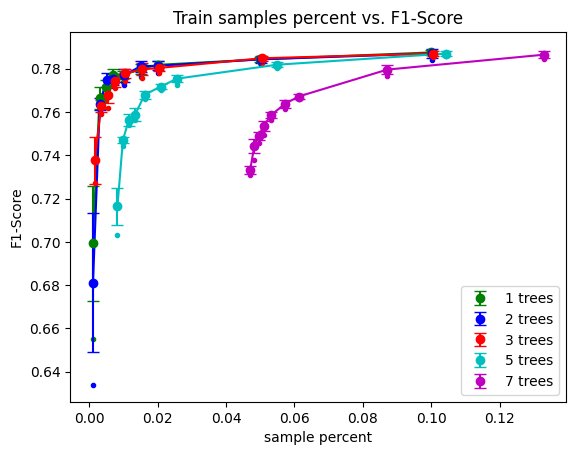

In [41]:
for i, e in enumerate(experimets[:-3]):
    e.print_scores(colors[i])
#trees20.print_scores('brown')
#cosample.print_scores('orange')
#random_small.print_scores('grey')
plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')
#plt.ylim((0.65,0.85))
#plt.xlim((0.04,0.31))
plt.legend()

In [ ]:
dataset.metric(dataset.y_test, model_path.model.predict(X_test))

0.8052749482226637

In [ ]:
experimets_big = [XgboostPathSampleA(f'{i} trees', model_path, i) for i in [1, 2, 3, 5, 7, 10, 13, 20]]

In [ ]:
for e in experimets_big:
    print ('#######################################')
    e.test_sample_method(dataset, print_results=True, trials_number=5)

#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7864085911965704, 94.71973538398743, 0.05002042873096723)
(0.7831461875735216, 86.25708675384521, 0.05002042873096723)
(0.7824714115036695, 83.14986181259155, 0.05002042873096723)
(0.7851462261149875, 87.2132306098938, 0.05002042873096723)


 17%|█▋        | 1/6 [07:13<36:09, 433.90s/it]

(0.7847553604377425, 82.16381669044495, 0.05002042873096723)
(0.7887151050815889, 149.11540842056274, 0.10001906681556942)
(0.7855368479160917, 148.05737018585205, 0.10001906681556942)
(0.7889206047150863, 151.32340216636658, 0.10001906681556942)
(0.7868581945884194, 149.57201385498047, 0.10001906681556942)


 33%|███▎      | 2/6 [19:42<41:17, 619.30s/it]

(0.7853711189654806, 150.902934551239, 0.10001906681556942)
(0.7929044304871838, 268.59187746047974, 0.20001361915397817)
(0.7929515418502203, 273.43102049827576, 0.20001361915397817)
(0.792302475415395, 274.51565861701965, 0.20001361915397817)
(0.7904024374761965, 270.2393128871918, 0.20001361915397817)


 50%|█████     | 3/6 [42:22<47:51, 957.17s/it]

(0.7917362711721045, 272.25072860717773, 0.20001361915397817)
(0.7954022017030448, 387.5370135307312, 0.300021790646365)
(0.7964414319000211, 389.15991139411926, 0.300021790646365)
(0.795380165114757, 389.9281737804413, 0.300021790646365)
(0.7951184372219161, 389.06326723098755, 0.300021790646365)


 67%|██████▋   | 4/6 [1:14:47<44:54, 1347.28s/it]

(0.7934504014065115, 389.32899594306946, 0.300021790646365)
(0.7985950955292722, 503.8165636062622, 0.40001361915397815)
(0.7962759204401185, 510.5251569747925, 0.40001361915397815)
(0.796545753979984, 508.13018345832825, 0.40001361915397815)
(0.7959914404966207, 505.6663484573364, 0.40001361915397815)


 83%|████████▎ | 5/6 [1:57:01<29:35, 1775.18s/it]

(0.796141560721765, 505.37391352653503, 0.40001361915397815)
(0.8022126509585339, 912.663711309433, 0.7500149810693759)
(0.8012444707824503, 920.1009573936462, 0.7500149810693759)
(0.799508828386332, 919.4856367111206, 0.7500149810693759)
(0.79832021888057, 922.7692534923553, 0.7500149810693759)


100%|██████████| 6/6 [3:13:31<00:00, 1935.33s/it]


(0.8002959830866808, 914.8460059165955, 0.7500149810693759)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7820679373868596, 90.1219413280487, 0.05010486748563179)
(0.7831366367006094, 90.39733624458313, 0.05010486748563179)
(0.7805511224598362, 89.37100458145142, 0.05010486748563179)
(0.7835835155735791, 87.62681078910828, 0.05010486748563179)


 17%|█▋        | 1/6 [07:24<37:01, 444.36s/it]

(0.7832954714337276, 86.79657888412476, 0.05010486748563179)
(0.7877207487968793, 153.99207663536072, 0.10010078173943834)
(0.7887157396849529, 155.47472071647644, 0.10010078173943834)
(0.7875108781015855, 155.494779586792, 0.10010078173943834)
(0.7896738211931721, 156.44363284111023, 0.10010078173943834)


 33%|███▎      | 2/6 [20:22<42:42, 640.54s/it]

(0.7860698625203889, 156.38537430763245, 0.10010078173943834)
(0.7918298232617209, 282.2100555896759, 0.20008443875466456)
(0.7914311720751043, 269.14246821403503, 0.20008443875466456)
(0.7887395707279792, 282.07213497161865, 0.20008443875466456)
(0.7919607760260365, 288.77749013900757, 0.20008443875466456)


 50%|█████     | 3/6 [43:49<49:32, 990.84s/it]

(0.7892793481028776, 285.3099343776703, 0.20008443875466456)
(0.793319679918924, 407.17196226119995, 0.3000871625854602)
(0.7933943712600173, 395.0500409603119, 0.3000871625854602)
(0.7943719274453298, 391.925794839859, 0.3000871625854602)
(0.7942403388035998, 397.348504781723, 0.3000871625854602)


 67%|██████▋   | 4/6 [1:16:59<46:10, 1385.27s/it]

(0.7942989051017599, 398.17874574661255, 0.3000871625854602)
(0.7962073271391987, 513.859263420105, 0.4000762672622777)
(0.7962265747282034, 511.5998435020447, 0.4000762672622777)
(0.7969638666300188, 511.9574372768402, 0.4000762672622777)
(0.7962229796963987, 507.6656849384308, 0.4000762672622777)


 83%|████████▎ | 5/6 [1:59:36<30:07, 1807.52s/it]

(0.7981119295571925, 510.7907931804657, 0.4000762672622777)
(0.8006440405067581, 936.4211273193359, 0.7500721815160842)
(0.7998138787250693, 919.5146327018738, 0.7500721815160842)
(0.7985939055121446, 922.5896005630493, 0.7500721815160842)
(0.8017922813543561, 935.7166829109192, 0.7500721815160842)


100%|██████████| 6/6 [3:16:48<00:00, 1968.16s/it]


(0.8007276265414472, 917.8347170352936, 0.7500721815160842)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.782938027632609, 87.3633873462677, 0.0503609075804211)
(0.7847276906378361, 88.43929648399353, 0.0503609075804211)
(0.7852493660185967, 88.98133969306946, 0.0503609075804211)
(0.7818038681674079, 90.01677465438843, 0.0503609075804211)


 17%|█▋        | 1/6 [07:23<36:58, 443.64s/it]

(0.7839887520770312, 88.79061722755432, 0.0503609075804211)
(0.7856612263089755, 155.9048571586609, 0.1003432026802495)
(0.7890105716275243, 149.92633938789368, 0.1003432026802495)
(0.7888301248148932, 154.1102991104126, 0.1003432026802495)
(0.7879237917426909, 155.5523955821991, 0.1003432026802495)


 33%|███▎      | 2/6 [20:12<42:20, 635.01s/it]

(0.7866220452427347, 153.40014457702637, 0.1003432026802495)
(0.7934699754382992, 276.8614749908447, 0.20030234521831503)
(0.789774410631904, 279.78324699401855, 0.20030234521831503)
(0.7906572929019142, 279.0119321346283, 0.20030234521831503)
(0.7924822814714816, 276.0626561641693, 0.20030234521831503)


 50%|█████     | 3/6 [43:24<49:02, 980.77s/it]

(0.7898970603841664, 280.2976002693176, 0.20030234521831503)
(0.7918678526048284, 396.17693734169006, 0.30035409800343205)
(0.7957676436355942, 396.0917603969574, 0.30035409800343205)
(0.7945240261526418, 397.6206245422363, 0.30035409800343205)
(0.7943749073426944, 396.43490719795227, 0.30035409800343205)


 67%|██████▋   | 4/6 [1:16:26<45:51, 1375.98s/it]

(0.7953372260302953, 395.1793780326843, 0.30035409800343205)
(0.7964848536059825, 514.1969211101532, 0.4003077928799063)
(0.7975452333086447, 510.8783106803894, 0.4003077928799063)
(0.7938756952227884, 512.1779453754425, 0.4003077928799063)
(0.7968829194120629, 507.53095507621765, 0.4003077928799063)


 83%|████████▎ | 5/6 [1:58:58<29:59, 1799.87s/it]

(0.7976286258733856, 506.28068256378174, 0.4003077928799063)
(0.8019031507718334, 916.2609755992889, 0.7502928118105303)
(0.7992030859225976, 919.6685140132904, 0.7502928118105303)
(0.8007363676759982, 910.7713477611542, 0.7502928118105303)
(0.8020353870191291, 918.292028427124, 0.7502928118105303)


100%|██████████| 6/6 [3:15:19<00:00, 1953.21s/it]


(0.8023295070898041, 915.405912399292, 0.7502928118105303)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7837383137764338, 97.01206159591675, 0.054912428839920466)
(0.7807205411480311, 95.3215274810791, 0.054912428839920466)
(0.7842886659424457, 96.29983186721802, 0.054912428839920466)
(0.7790484318327289, 93.10278654098511, 0.054912428839920466)


 17%|█▋        | 1/6 [07:57<39:45, 477.01s/it]

(0.7809860957092895, 95.22555780410767, 0.054912428839920466)
(0.7881460126340781, 159.08774399757385, 0.10430637648789257)
(0.7882142553010304, 162.13174200057983, 0.10430637648789257)
(0.7855899460790557, 160.85801935195923, 0.10430637648789257)
(0.7849654060019525, 160.50196838378906, 0.10430637648789257)


 33%|███▎      | 2/6 [21:18<44:31, 667.87s/it]

(0.7851357384298135, 158.78711891174316, 0.10430637648789257)
(0.7929771057034543, 281.9191863536835, 0.20352191321875085)
(0.7916737252244621, 278.4493942260742, 0.20352191321875085)
(0.7908880734723311, 282.3060493469238, 0.20352191321875085)
(0.7915436099012004, 281.090847492218, 0.20352191321875085)


 50%|█████     | 3/6 [44:41<50:10, 1003.34s/it]

(0.7904735624376472, 278.60562324523926, 0.20352191321875085)
(0.7951664193343227, 400.41927194595337, 0.30368806689728434)
(0.795766299745978, 400.25479102134705, 0.30368806689728434)
(0.7947000211999151, 400.0820744037628, 0.30368806689728434)
(0.7927053989367335, 395.8286979198456, 0.30368806689728434)


 67%|██████▋   | 4/6 [1:17:56<46:30, 1395.18s/it]

(0.7956575104753038, 398.9757807254791, 0.30368806689728434)
(0.7977140438141603, 517.1807227134705, 0.403233187154414)
(0.7983699804737243, 514.3139719963074, 0.403233187154414)
(0.7960336334295907, 512.6959636211395, 0.403233187154414)
(0.7947409650032816, 516.0853862762451, 0.403233187154414)


 83%|████████▎ | 5/6 [2:00:49<30:19, 1819.93s/it]

(0.7953335454449041, 512.4180252552032, 0.403233187154414)
(0.8005593575862874, 918.7643492221832, 0.7528586604200147)
(0.8007104645507792, 921.8059628009796, 0.7528586604200147)
(0.8020602452873999, 922.3992853164673, 0.7528586604200147)
(0.799754455780873, 915.2472498416901, 0.7528586604200147)


100%|██████████| 6/6 [3:17:25<00:00, 1974.30s/it]


(0.8005075605371683, 916.8711583614349, 0.7528586604200147)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7767178385663444, 144.75786972045898, 0.08714079481382617)
(0.7784489313170566, 143.9906883239746, 0.08714079481382617)
(0.7787487040602585, 143.86896777153015, 0.08714079481382617)
(0.7793395427603725, 144.7067813873291, 0.08714079481382617)


 17%|█▋        | 1/6 [12:00<1:00:00, 720.08s/it]

(0.7815307679267673, 142.66442012786865, 0.08714079481382617)
(0.786076377154444, 203.06736993789673, 0.13281398959496635)
(0.7846526244267029, 200.33244609832764, 0.13281398959496635)
(0.7874058921529344, 198.88672518730164, 0.13281398959496635)
(0.7837476950467349, 202.21565127372742, 0.13281398959496635)


 33%|███▎      | 2/6 [28:47<59:16, 889.10s/it]  

(0.7845521565968987, 202.78440403938293, 0.13281398959496635)
(0.7924512316522991, 316.70278215408325, 0.22699043935390734)
(0.7933996192088005, 315.8414719104767, 0.22699043935390734)
(0.7911840821348267, 313.54707431793213, 0.22699043935390734)
(0.7916005165004975, 315.16121768951416, 0.22699043935390734)


 50%|█████     | 3/6 [55:04<1:00:09, 1203.05s/it]

(0.7905518483211524, 315.1690409183502, 0.22699043935390734)
(0.7965635447966481, 428.9356617927551, 0.3247868602402419)
(0.7971548329734536, 426.59110927581787, 0.3247868602402419)
(0.7960618251111582, 425.2262716293335, 0.3247868602402419)
(0.7951705147214573, 428.9050486087799, 0.3247868602402419)


 67%|██████▋   | 4/6 [1:30:44<52:25, 1572.91s/it]

(0.7935665938169704, 429.9076817035675, 0.3247868602402419)
(0.7970640494119638, 539.3277449607849, 0.42217470650723177)
(0.7983075946689232, 540.3399407863617, 0.42217470650723177)
(0.7956689083449647, 539.2952284812927, 0.42217470650723177)
(0.7957093894131086, 534.6325490474701, 0.42217470650723177)


 83%|████████▎ | 5/6 [2:15:35<32:56, 1976.19s/it]

(0.7969222313822478, 537.2244935035706, 0.42217470650723177)
(0.8014704328903726, 937.4173700809479, 0.7665649769836298)
(0.8005333784870676, 944.8862144947052, 0.7665649769836298)
(0.8014897263897414, 943.3499052524567, 0.7665649769836298)
(0.8006609329322544, 941.7220923900604, 0.7665649769836298)


100%|██████████| 6/6 [3:33:58<00:00, 2139.81s/it]


(0.8030741295948314, 935.5060396194458, 0.7665649769836298)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7865363093101336, 305.9081447124481, 0.19743415139051562)
(0.7865972398611464, 302.74000120162964, 0.19743415139051562)
(0.7839257721476083, 303.161581993103, 0.19743415139051562)
(0.7848449571383215, 328.9507706165314, 0.19743415139051562)


 17%|█▋        | 1/6 [26:06<2:10:30, 1566.15s/it]

(0.7864379534254109, 325.14267468452454, 0.19743415139051562)
(0.7894503265073226, 356.59418511390686, 0.23356849072535615)
(0.7904070258402296, 346.55377316474915, 0.23356849072535615)
(0.7876619527479042, 345.4928472042084, 0.23356849072535615)
(0.7905469792262245, 420.64284658432007, 0.23356849072535615)


 33%|███▎      | 2/6 [57:42<1:57:22, 1760.53s/it]

(0.790204461753376, 426.975558757782, 0.23356849072535615)
(0.7966299032579013, 518.1144552230835, 0.31206929425544083)
(0.7958452570217276, 511.67737913131714, 0.31206929425544083)
(0.7945524139827014, 514.3020594120026, 0.31206929425544083)
(0.7941014915282884, 437.6601333618164, 0.31206929425544083)


 50%|█████     | 3/6 [1:37:58<1:42:58, 2059.59s/it]

(0.795790454410706, 433.32673025131226, 0.31206929425544083)
(0.7973212776744971, 532.3346412181854, 0.3983139487375044)
(0.7968130866865849, 533.8417918682098, 0.3983139487375044)
(0.7973310739250159, 530.3057601451874, 0.3983139487375044)
(0.7972433038073695, 532.3784453868866, 0.3983139487375044)


 67%|██████▋   | 4/6 [2:22:20<1:16:35, 2297.62s/it]

(0.7980630973526178, 533.2339351177216, 0.3983139487375044)
(0.7973573878795579, 630.2846720218658, 0.48622558766649415)
(0.7996871763437677, 632.7860615253448, 0.48622558766649415)
(0.7989428057934244, 637.8870780467987, 0.48622558766649415)
(0.8005913410770854, 633.5641505718231, 0.48622558766649415)


 83%|████████▎ | 5/6 [3:15:07<43:30, 2610.92s/it]  

(0.7989085601878293, 631.3778800964355, 0.48622558766649415)
(0.7998049152865836, 1026.5459825992584, 0.8047421894151935)
(0.8008285599543447, 1034.2553417682648, 0.8047421894151935)
(0.801301967746708, 1018.7485730648041, 0.8047421894151935)
(0.8023009897639793, 1011.5008087158203, 0.8047421894151935)


100%|██████████| 6/6 [4:40:02<00:00, 2800.39s/it]


(0.8025876284300876, 1002.7984251976013, 0.8047421894151935)
#######################################


  0%|          | 0/6 [00:00<?, ?it/s]

(0.7961280461917297, 555.8754110336304, 0.3671478767738948)
(0.7957774898579045, 540.8669512271881, 0.3671478767738948)
(0.7976447663828525, 548.2576625347137, 0.3671478767738948)
(0.7978727912199669, 546.1245126724243, 0.3671478767738948)


 17%|█▋        | 1/6 [45:41<3:48:26, 2741.29s/it]

(0.7977721562041623, 549.692001581192, 0.3671478767738948)
(0.7975860243515087, 575.9673154354095, 0.3946095388554463)
(0.7983378561736771, 581.8179445266724, 0.3946095388554463)
(0.7973637365431889, 584.2888991832733, 0.3946095388554463)
(0.7986695197135654, 579.9699580669403, 0.3946095388554463)


 33%|███▎      | 2/6 [1:34:00<3:08:57, 2834.31s/it]

(0.7984313725490197, 576.9274299144745, 0.3946095388554463)
(0.799813424924734, 640.5743019580841, 0.4538228965216681)
(0.7994326961749328, 647.3669164180756, 0.4538228965216681)
(0.7990609732884969, 641.9306952953339, 0.4538228965216681)
(0.7989256862496299, 644.0610563755035, 0.4538228965216681)


 50%|█████     | 3/6 [2:27:45<2:30:37, 3012.60s/it]

(0.7986103755798928, 650.2798960208893, 0.4538228965216681)
(0.7997377492967873, 716.6502766609192, 0.5203933211668891)
(0.7994232889491986, 716.4997923374176, 0.5203933211668891)
(0.801808081448155, 717.5820097923279, 0.5203933211668891)
(0.8001014820609315, 726.5010900497437, 0.5203933211668891)


 67%|██████▋   | 4/6 [3:27:47<1:48:10, 3245.24s/it]

(0.7994760305085462, 724.0433602333069, 0.5203933211668891)
(0.8006276106269745, 804.8078427314758, 0.589902759240596)
(0.801193726585815, 799.3369328975677, 0.589902759240596)
(0.8015393073117096, 804.1790618896484, 0.589902759240596)
(0.8010308625023764, 806.5624194145203, 0.589902759240596)


 83%|████████▎ | 5/6 [10:14:59<3:01:25, 10885.35s/it]

(0.8008542671064873, 21216.28907227516, 0.589902759240596)
